In [1]:
# This is only needed if the notebook is run in VSCode
import nbs_pipeline.utils.vscode  as vs
vs.DisplayHandle.update = vs.update_patch


# OR-ELM: Online Recurrent Extreme Learning Machine for time-series prediction

> This notebook applies visual analytics to [OR_ELM](https://github.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine) algorithm

In [2]:
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!from tchub.all import *
import wandb
wandb_api = wandb.Api()
from fastcore.all import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.schedule import *
from dvats.all import *
import nbs.orelm_torch as orelm

/home/macu/lib/orelm/
El directorio existe: /home/macu/lib/orelm/
['/home/macu/work/nbs_pipeline', '/home/macu/env/lib/python310.zip', '/home/macu/env/lib/python3.10', '/home/macu/env/lib/python3.10/lib-dynload', '', '/home/macu/env/lib/python3.10/site-packages', '/home/macu/env/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/macu/lib/tsai', '/home/macu/work']
['/home/macu/work/nbs_pipeline', '/home/macu/env/lib/python310.zip', '/home/macu/env/lib/python3.10', '/home/macu/env/lib/python3.10/lib-dynload', '', '/home/macu/env/lib/python3.10/site-packages', '/home/macu/env/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/macu/lib/tsai', '/home/macu/work', '/home/macu/lib/orelm/']


For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook, make sure you have the `$WANDB_API_KEY` environment varibale defined with your API_KEY (run in a terminal `echo $WANDB_API_KEY` to see it). If not, run in a terminal `wandb login [API_KEY]`. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account.

## Notebook configuration

In [3]:
import nbs_pipeline.utils.config as cfg
config, job_type, dataSet = cfg.get_artifact_config_ORELM(True)

Current: /home/macu/work/nbs_pipeline
yml: ./config/02c-encoder_orelm.yaml
... About to replace includes with content
Before configuration reading 
-include: None
-user_preferences:
	-use_wandb: False
	-wdb:
		-user: mi-santamaria
		-project_name: test-project
		-version: 0
		-mode: offline
		-artifacts_path: ./data/wandb_artifacts
	-data:
		-folder: ~/data/
		-fname: speed_6005
		-ftype: .csv
		-cols: [1]
		-freq: 1s
	-artifact:
		-alias: TiltABP
	-directories:
		-tmp: tmp
		-data: ~/data/speed_6005.csv
-data:
	-name: speed_6005
	-path: ~/data/speed_6005.csv
	-alias: TiltABP
	-cols: [1]
	-csv_config:
	-date_offset: None
	-date_format: %Y-%m-%d %H:%M:%S
	-freq: 1s
	-joining_train_test: False
	-missing_values:
		-technique: None
		-constant: None
	-normalize_training: False
	-range_training: None
	-range_testing: None
	-resampling_freq: None
	-start_date: None
	-test_split: None
	-time_col: None
-wandb:
	-user: mi-santamaria
	-dir: ~/test-project
	-enabled: False
	-group: None
	-log_lea

In [4]:
print("Project: "+config.wandb_project)
run = wandb.init(
    entity          = config.wandb_entity,
    project         = config.wandb_project,
    group           = config.wandb_group,
    job_type        = job_type,
    allow_val_change= True,
    mode            = 'online' if config.use_wandb else 'disabled',
    config          = config,
    resume          = False
)
config = run.config  # Object for storing hyperparameters
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

Project: test-project


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Loading the datasets

In [5]:
print("Used dataSet:")
cfg.recursive_print_attrdict(dataSet)

Used dataSet:
-folder: ~/data/
-fname: speed_6005
-ftype: .csv
-cols: [1]
-freq: 1s


### Sliding window features

$Z$ is a $w \times s \times t$ matrix. The first step consists in slicing the original multivariate time series into slices of shape ($w \times d$), as shown in this figure from the paper.
<img src="https://i.imgur.com/R9Fx8uO.png" style="width:800px;height:400px"/>

The hyperparameters of this sliding window approach are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [6]:
print("--- SLIDING WINDOW --")
print("Len: " + str(config.w))
print("Stride: " + str(config.stride))

--- SLIDING WINDOW --
Len: 200
Stride: 1


In [7]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])

In [8]:
#get artiffact
train_artifact = artifacts_gettr(config.train_artifact)
#convert to pandas dataset
df_train = train_artifact.to_df()
df_train.head(5)

wandb:   1 of 1 files downloaded.  


,timestamp,value
1970-01-01 00:00:00,2015-08-31 18:22:00,90
1970-01-01 00:00:01,2015-08-31 18:32:00,80
1970-01-01 00:00:02,2015-08-31 18:57:00,84
1970-01-01 00:00:03,2015-08-31 19:07:00,94
1970-01-01 00:00:04,2015-08-31 19:12:00,90


In [9]:
# Subset of variables
if dataSet.cols:
    df_train = df_train.iloc[:, dataSet.cols]
print(f'Num. variables: {len(df_train.columns)}')
df_train.head(5)

Num. variables: 1


,value
1970-01-01 00:00:00,90
1970-01-01 00:00:01,80
1970-01-01 00:00:02,84
1970-01-01 00:00:03,94
1970-01-01 00:00:04,90


In [10]:
df_train

,value
1970-01-01 00:00:00,90
1970-01-01 00:00:01,80
1970-01-01 00:00:02,84
1970-01-01 00:00:03,94
1970-01-01 00:00:04,90
...,...
1970-01-01 00:41:35,81
1970-01-01 00:41:36,89
1970-01-01 00:41:37,87
1970-01-01 00:41:38,82


In [11]:
# standardize data by subtracting mean and dividing by std
meanSeq     = np.mean(df_train['value'])
print(meanSeq)
stdSeq      = np.std(df_train['value'])
print(stdSeq)
df_train['value'] = (df_train['value'] - meanSeq)/stdSeq
df_train.head()

81.9068
8.744856417346142


,value
1970-01-01 00:00:00,0.925481
1970-01-01 00:00:01,-0.218048
1970-01-01 00:00:02,0.239364
1970-01-01 00:00:03,1.382893
1970-01-01 00:00:04,0.925481


In [12]:
#Setup Training windows
X_train, _ = sw(df_train) #Windows
data = {
    "Description": [
        "Dataset shape", 
        "Number of Sliding windows", 
        "Sliding window shape"
    ],
    "Value": [
        str(df_train.shape), 
        str(X_train.shape[0]), 
        f"({X_train.shape[1]}, {X_train.shape[2]})"
    ]
}

training_info = pd.DataFrame(data)
training_info

,Description,Value
0,Dataset shape,"(2500, 1)"
1,Number of Sliding windows,2301
2,Sliding window shape,"(1, 200)"


In [13]:
df_train.head(5)

,value
1970-01-01 00:00:00,0.925481
1970-01-01 00:00:01,-0.218048
1970-01-01 00:00:02,0.239364
1970-01-01 00:00:03,1.382893
1970-01-01 00:00:04,0.925481


In [14]:
if config.valid_artifact:
    valid_artifact = artifacts_gettr(config.valid_artifact)
    df_val = valid_artifact.to_df()
    X_valid, _ = sw(df_val)
    df_val.shape, X_valid.shape
    print("valid_artifact")
    print(valid_artifact)
    print("df_val")
    print(df_val)
    print("X_valid")
    print(X_valid)
    print("df_val.shape")
    print(df_val.shape)
    print("X_valid.shape")
    print(X_valid.shape)
else:
    print("No validation artifact. Random items to get:", config.valid_size)

No validation artifact. Random items to get: 0.1


## TODO: METER EXPLICACIÓN DE OR-ELM


todo: AQUI VA LA EXPLICACIÓN CON EL EJEMPLO QUE SE META EN EL PAPER

### Create the model

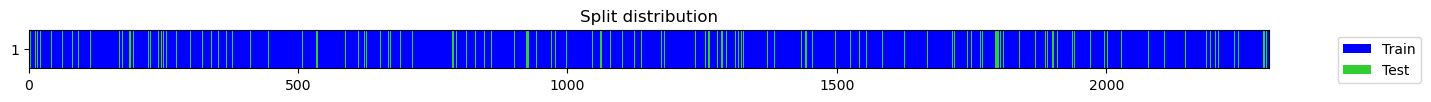

([569, 2266, 109, 152, 117, 1779, 298, 519, 554, 302, 1006, 1837, 1461, 329, 2150, 2205, 687, 1478, 654, 1104, 885, 1206, 2225, 986, 798, 1930, 1578, 1498, 1724, 1178, 2110, 1209, 1750, 1708, 171, 1896, 292, 281, 1545, 288, 1911, 912, 1852, 1377, 1596, 577, 108, 1199, 1592, 1988, 1166, 25, 1035, 841, 932, 1242, 179, 1534, 1257, 1012, 1640, 1577, 1425, 2047, 208, 158, 818, 1037, 1472, 166, 2130, 1959, 197, 838, 634, 2156, 1204, 1804, 1691, 1145, 490, 375, 1722, 2190, 132, 719, 628, 766, 380, 1505, 528, 2090, 2151, 1378, 959, 424, 1814, 913, 242, 2200, 348, 1666, 2224, 2273, 1594, 1605, 1459, 146, 745, 817, 1858, 1383, 1280, 1405, 545, 535, 596, 483, 1587, 1663, 540, 215, 216, 2283, 1871, 1985, 434, 861, 286, 1941, 1895, 428, 1761, 2168, 212, 2126, 649, 1977, 1197, 1462, 2211, 1358, 1706, 1879, 1716, 862, 1238, 1740, 1602, 685, 1926, 79, 1590, 933, 618, 796, 1193, 689, 570, 1857, 1446, 235, 515, 2069, 701, 1272, 1350, 530, 744, 1908, 1015, 1080, 1051, 694, 2013, 1954, 2045, 965, 1062, 11

In [15]:
#Split dataset
random.seed = config.random_seed
if config.valid_artifact:
    X, y, splits  = combine_split_data(xs=[X_train, X_valid], ys=[X_train, X_valid])
else:
    X = X_train
    y = X_train
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
splits
print(splits)

In [16]:
#Create and train the model
#features = pd.DataFrame(dls.dataset[0][0])
#targets = pd.DataFrame(dls.dataset[0][1]) #1

#print("dls len: " + str(len(dls.dataset)))

#print("Features shape: " + str(features.shape))
#print("Targets shape: " + str(features.shape))

#dls.dataset

In [17]:
numLags     = X_train.shape[0] #config.epochs
nDimInput   = numLags
nDimOutput  = 1 #targets.shape[1] #1
numNeurons  = config.numHiddenNeurons #nDimInput  #config.numHiddenNeurons
algorithm   = config.algorithm
LN              = config.LN 
AE              = config.AE
InWeightFF      = config.inputWeightForgettingFactor #1.0
OutWeightFF     = config.outputWeightForgettingFactor #0.92
HiddenWeightFF  = config.inputWeightForgettingFactor #1.0
lamb            = config.lamb
predictionStep  = config.stride #5


In [18]:

data_to_append = {
    "Description": [
        "inputs/Charasteristics", 
        "Targets shape", 
        "X_train shape", 
        "Input Weights", 
        "Hidden Weights", 
        "Hidden A", 
        "Bias", 
        "Features"
    ],
    "Value": [
        str(nDimInput),
        str(y.shape),
        str(X_train.shape),
        f"({numNeurons}, {nDimInput})",
        f"({numNeurons}, {numNeurons})",
        f"({nDimOutput}, {numNeurons})",
        f"({nDimOutput}, {numNeurons})",
        f"({nDimOutput}, {nDimInput})"
    ]
}
data_to_append = pd.DataFrame(data_to_append)
training_info = training_info.append(data_to_append, ignore_index = True)
training_info.head

<bound method NDFrame.head of                   Description           Value
0               Dataset shape       (2500, 1)
1   Number of Sliding windows            2301
2        Sliding window shape        (1, 200)
3      inputs/Charasteristics            2301
4               Targets shape  (2301, 1, 200)
5               X_train shape  (2301, 1, 200)
6               Input Weights      (25, 2301)
7              Hidden Weights        (25, 25)
8                    Hidden A         (1, 25)
9                        Bias         (1, 25)
10                   Features       (1, 2301)>

Train the model with fastai Learner class, to abstract from Pytorch's training loop




To track the performance of this model fit, go to the project dashboard in Weights & Biases. The link is provided at the beginning of this notebook, after the execution of the function `wandb.init()'' 

Finally, log the learner to be used by the next notebook in the pipeline

In [19]:
m = orelm.ORELM_torch(
    inputs                      =   nDimInput,
    outputs                     =   nDimOutput,
    numHiddenNeurons            =   config.numHiddenNeurons,
    activationFunction          =   config.activationFunction,
    LN                          =   config.LN,
    AE                          =   config.AE,
    ORTH                        =   config.ORTH,
    inputWeightForgettingFactor =   config.inputWeightForgettingFactor,
    outputWeightForgettingFactor=   config.outputWeightForgettingFactor
)
m.initializePhase(lamb=0.0001)
print(m)

inputs
2301
outputs
1
numNeurons
25
Out weight FF
0.92
(25, 2301)
--> Initialize_Phase: Input Weights initialized. Shape: (25, 2301)
ORELM_torch()


In [20]:
tfms = [ToFloat(), ToFloat()]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)

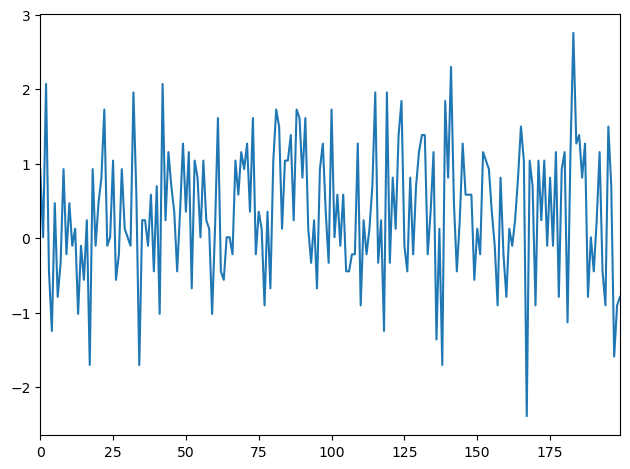

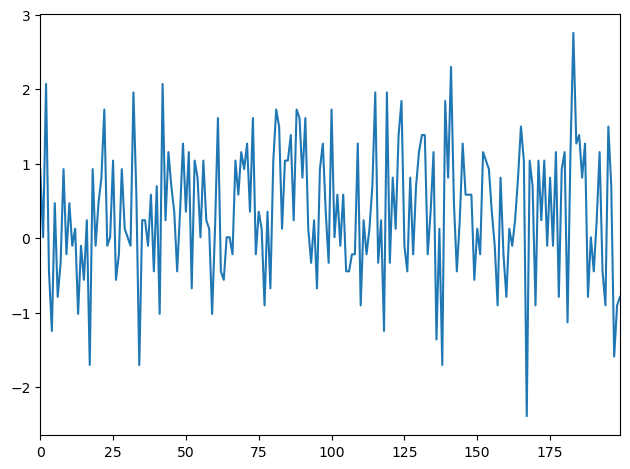

In [21]:
tfms = [ToFloat(), ToFloat()]
batch_tfms = [TSStandardize(by_sample=True)]
#DataLoader

dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dls.dataset[0][0].show(), ToTSTensor()(dls.dataset[0][1]).show()
learn =  Learner(
    dls         = dls, 
    model       = m, 
    loss_func   = nn.MSELoss(), #
    opt_func    = Adam, #Creates an optimizer
    cbs         = [WandbCallback(log_preds=False)] #List of callbacks
)

"""
DLS:
Is a DataLoaders object, that you can create from standard PyTorch dataloaders. 
By doing so, you will lose all showing functionality like show_batch/show_results. 
You can check the data block API or the mid-level data API tutorial to learn 
how to use fastai to gather your data!
MODEL: 
is a standard PyTorch model. 
You can use anyone you like, 
just make sure it accepts the number of inputs you have in your 
DataLoaders and returns as many outputs as you have targets.
OPT_FUNC: 
Can be any loss function you like. 
It needs to be one of fastai’s if you want to use Learn.predict or Learn.get_preds, 
or you will have to implement special methods (see more details after the BaseLoss documentation).
"""


In [29]:
print(m)

ORELM_torch()


In [32]:

lr_valley, lr_steep = learn.lr_find(suggest_funcs=[valley, steep])
learn.fit_one_cycle(1, lr_max=lr_valley)
#learn.fit_one_cycle(config.epochs, lr_max=lr_valley)
learn.plot_metrics()

IndexError: list index out of range

In [22]:
X = np.array([X[w][0] for w in range(X_train.shape[0])]).T
T = np.array([y[w][0] for w in range(X_train.shape[0])]).T   
print('Input shape: ', str(X.shape))
print('Target shape: ', str(T.shape))

Input shape:  (200, 2301)
Target shape:  (200, 2301)


In [23]:
predictions = []
target = []
maxStep = X.shape[0]-predictionStep-1
print("Num steps: " + str(maxStep))

Num steps: 198


In [24]:
step = 0
for i in range(maxStep):
    training_dataset = X[[i],:]
    targets = T[[i],:]
    features = X[[i+1],:]
    print("Training["+str(i)+"] shape: " + str(training_dataset.shape))
    print("Targets["+str(i)+"] shape: " + str(targets.shape))
    m.train(training_dataset, targets)
    Y = m.predict(features)
    predictions.append(Y[0][0])
    target.append(T[i][0])
    print (str(step)+"th/"+str(maxStep)+" ("+str(i)+") timeStep of "+str(maxStep) +" -  target: "+str(target[i]) + " |    prediction: "+str(predictions[-1]))

Training[0] shape: (1, 2301)
Targets[0] shape: (1, 2301)
samples = weights: 1 | outputs: 2301
Features shape: (1, 2301)=> Columns: 1
Weights number: 1 = 1
0th/198 (0) timeStep of 198 -  target: 0.925481175876881 |    prediction: 0.7302735092015413
Training[1] shape: (1, 2301)
Targets[1] shape: (1, 2301)
samples = weights: 1 | outputs: 2301
Features shape: (1, 2301)=> Columns: 1
Weights number: 1 = 1
0th/198 (1) timeStep of 198 -  target: -0.21804817700811066 |    prediction: 0.17802429597292674
Training[2] shape: (1, 2301)
Targets[2] shape: (1, 2301)
samples = weights: 1 | outputs: 2301
Features shape: (1, 2301)=> Columns: 1
Weights number: 1 = 1
0th/198 (2) timeStep of 198 -  target: 0.23936356414588597 |    prediction: 0.19017734458523877
Training[3] shape: (1, 2301)
Targets[3] shape: (1, 2301)
samples = weights: 1 | outputs: 2301
Features shape: (1, 2301)=> Columns: 1
Weights number: 1 = 1
0th/198 (3) timeStep of 198 -  target: 1.3828929170308777 |    prediction: 0.6318232655640945


# Evaluation: Calculate total Normalizedd Root Mean Square Error (NRMSE)

In [25]:
# Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq
  
def computeSquareDeviation(predictions, truth):
  squareDeviation = np.square(predictions-truth)
  return squareDeviation

# Calculate NRMSE from skip_eval to the end
skip_eval=100
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))

NRMSE 1.0528272152504494


In [26]:
print("Target len: " + str(len(target)) + str(target))
print("Prediction len: " + str(len(predictions))+str(predictions))

Target len: 198[ 90.  80.  84.  94.  90.  91.  62.  96.  75.  84.  86.  93.  69.  88.
  71.  74.  68.  88.  71.  87.  82.  68.  73.  69.  57.  43.  47.  73.
  78.  83.  87.  77.  80.  69.  63.  78.  66.  72.  54.  73.  82.  90.
  92.  63.  69.  97.  85.  86.  84.  88.  78.  88.  80.  75.  88.  69.
  84.  76.  84.  87.  87.  67.  62.  84.  89.  81.  84.  85.  89.  81.
  91.  82.  94.  85. 102.  76.  86.  87.  83.  93.  87.  80.  87.  75.
  75.  68.  94.  77.  82.  94.  78.  84.  82. 100.  68.  81.  93.  91.
  78.  77.  85.  84.  72.  58.  80.  66.  86.  74.  86.  71.  87.  73.
  76.  66.  68.  86.  90.  83.  75.  84.  88.  85.  92.  94.  92.  77.
  93.  77.  73.  88.  76.  93.  76.  87.  90.  91. 102.  75.  68.  81.
  93.  93.  84.  87.  80.  86.  67.  94.  79.  70.  82.  85.  88.  85.
  72.  78.  79.  80.  65.  80.  69.  91.  97.  94.  96.  77.  79.  78.
  71.  88.  76.  71.  64.  66.  74.  70.  75.  79.  71.  74.  95.  98.
  92.  66.  67.  59.  75.  90.  76.  71.  87.  89.  79.  77.  

## Plot predictions and target values

OSELM
encoder_ORELM


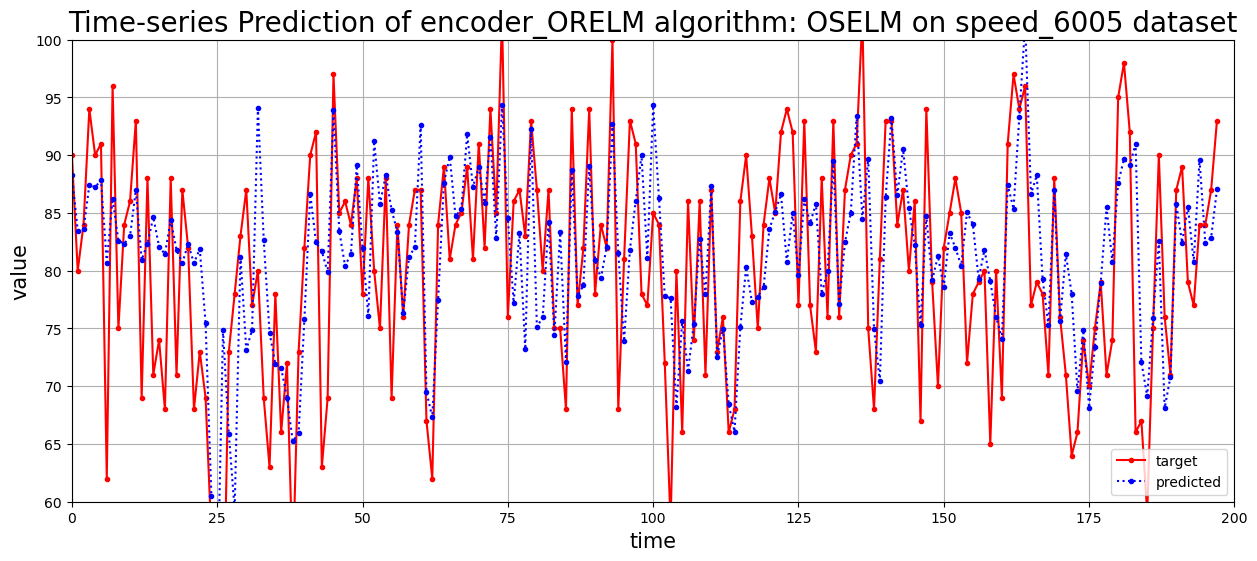

Prediction plot is saved to./predictionPlot.png


In [27]:

algorithm = config.algorithm
print(algorithm)
print(config.job_type)
plt.figure(figsize=(15,6))

targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([0, 200])
plt.ylim([60, 100])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+ config.job_type + ' algorithm: ' + algorithm +' on '+dataSet.fname+' dataset' ,fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.savefig(plot_path,bbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)
print('Prediction plot is saved to'+plot_path)

## Online learning and prediction of OR-ELM

In [28]:
run.finish()